In [1]:
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pr_input_dict = {
    'mean': 'figures/mean_bias_pr.yaml',
    'cycle': 'figures/seasonal_cycle_pr.yaml',
    'std(1yr)': 'figures/interannual_variability_pr.yaml',
#    'wet days': 'figures/wet-day-freq_bias_pr.yaml',
#    'R10mm': 'figures/r10mm.yaml',
#    'R20mm': 'figures/r20mm.yaml',
#    'R95pTOT': 'figures/r95ptot.yaml',
#    'R99pTOT': 'figures/r99ptot.yaml',
    'pct99': 'figures/pct99_pr.yaml',
    '1-in-10yr': 'figures/extreme_event_pr.yaml',
}

tasmin_input_dict = {
    'mean': 'figures/mean_bias_tasmin.yaml',
    'cycle': 'figures/seasonal_cycle_tasmin.yaml',
    'std(1yr)': 'figures/interannual_variability_tasmin.yaml',
#    'CSDI': 'figures/csdi.yaml',
    'pct01': 'figures/pct01_tasmin.yaml',
    '1-in-10yr': 'figures/extreme_event_tasmin.yaml',
}

tasmax_input_dict = {
    'mean': 'figures/mean_bias_tasmax.yaml',
    'cycle': 'figures/seasonal_cycle_tasmax.yaml',
    'std(1yr)': 'figures/interannual_variability_tasmax.yaml',
#    'WSDI': 'figures/wsdi.yaml',
    'pct99': 'figures/pct99_tasmax.yaml',
    '1-in-10yr': 'figures/extreme_event_tasmax.yaml',
}

In [3]:
def mean_pct_change(df):
    """Calculate the average percentage change"""
    
    df_pct_change = ((df - df.loc['RCM']) / df.loc['RCM']) * 100
    
    return df_pct_change.mean(axis=1)
    

def read_data(index, infile, gcms='all'):
    """Read index data
    
    Subset can be:
       'ERA5'  - ERA5 only
       'CMIP6' - CMIP6 models only
       'all'   - Both ERA5 and CMIP6
    """

    with open(infile, 'r') as reader:
        mae_dict = yaml.load(reader, Loader=yaml.BaseLoader)
        
    hist_df = pd.DataFrame.from_dict(mae_dict['historical']).astype('float')
    xval_df = pd.DataFrame.from_dict(mae_dict['xvalidation']).astype('float')

    assert gcms in ['ERA5', 'CMIP6', 'all']
    if gcms == 'ERA5':
        hist_df = hist_df.loc[:, hist_df.columns.str.contains('ERA5')]
        xval_df = xval_df.loc[:, xval_df.columns.str.contains('ERA5')]
        assert hist_df.shape[1] == 3
        assert xval_df.shape[1] == 3
    elif gcms == 'CMIP6':
        hist_df = hist_df.loc[:, ~hist_df.columns.str.contains('ERA5')]
        xval_df = xval_df.loc[:, ~xval_df.columns.str.contains('ERA5')]
        assert hist_df.shape[1] == 7
        assert xval_df.shape[1] == 7
    
    return hist_df, xval_df

In [4]:
def var_df(var_input_dict, gcms='all'):
    """Get DataFrame for a given variable"""

    hist_mean_ds_list = []
    xval_mean_ds_list = []
    hist_pct_change_ds_list = []
    xval_pct_change_ds_list = []
    index_list = []
    for index, infile in var_input_dict.items():
        print(index, infile)
        hist_df, xval_df = read_data(index, infile, gcms=gcms)
        hist_mean_ds_list.append(hist_df.mean(axis=1))
        xval_mean_ds_list.append(xval_df.mean(axis=1))
        hist_pct_change_ds_list.append(mean_pct_change(hist_df))
        xval_pct_change_ds_list.append(mean_pct_change(xval_df))
        index_list.append(index)

    hist_mean_df = pd.DataFrame(hist_mean_ds_list, index=index_list)
    xval_mean_df = pd.DataFrame(xval_mean_ds_list, index=index_list)
    hist_pct_change_df = pd.DataFrame(hist_pct_change_ds_list, index=index_list)
    xval_pct_change_df = pd.DataFrame(xval_pct_change_ds_list, index=index_list)

    hist_column_order = ['GCM', 'RCM', 'ECDFm', 'QME', 'MRNBC', 'MBCn']
    xval_column_order = ['GCM', 'RCM', 'ECDFm', 'QME', 'MRNBC', 'MBCn', 'QDC', 'training']
    hist_mean_df = hist_mean_df[hist_column_order]
    xval_mean_df = xval_mean_df[xval_column_order]
    hist_pct_change_df = hist_pct_change_df[hist_column_order]
    xval_pct_change_df = xval_pct_change_df[xval_column_order]
    
    df_dict = {
        'hist_mean': hist_mean_df[hist_column_order],
        'xval_mean': xval_mean_df[xval_column_order],
        'hist_pct_change': hist_pct_change_df[hist_column_order],
        'xval_pct_change': xval_pct_change_df[xval_column_order],
    }
    
    return df_dict

In [5]:
def plot_task(task):
    """Plot results for a given task"""

    assert task in ['hist', 'xval']
    ncols = {'hist': 6, 'xval': 8} 
    
    fig = plt.figure(figsize=[20, 10])
    ax1 = fig.add_subplot(321)
    ax2 = fig.add_subplot(323)
    ax3 = fig.add_subplot(325)
    ax4 = fig.add_subplot(322)
    ax5 = fig.add_subplot(324)
    ax6 = fig.add_subplot(326)

    # tasmin, CMIP6
    tasmin_df_dict_cmip6 = var_df(tasmin_input_dict, gcms='CMIP6')
    g1 = sns.heatmap(
        tasmin_df_dict_cmip6[f'{task}_pct_change'],
        ax=ax1,
        annot=tasmin_df_dict_cmip6[f'{task}_mean'],
        fmt=".2f",
        cbar_kws={'label': 'bias (% change from RCM bias)'},
        vmin=-100,
        vmax=100,
        cmap='RdBu_r',
        linewidths=0.5,
    )
    g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
    ax1.set_title('(a) Minimum temperature, CMIP6')
    ax1.hlines([0, 2, 4, 6], *ax1.get_xlim(), colors='black')
    ax1.vlines([0, ncols[task]], *ax1.get_ylim(), colors='black')

    # tasmax, CMIP6
    tasmax_df_dict_cmip6 = var_df(tasmax_input_dict, gcms='CMIP6')
    g2 = sns.heatmap(
        tasmax_df_dict_cmip6[f'{task}_pct_change'],
        ax=ax2,
        annot=tasmax_df_dict_cmip6[f'{task}_mean'],
        fmt=".2f",
        cbar_kws={'label': 'bias (% change from RCM bias)'},
        vmin=-100,
        vmax=100,
        cmap='RdBu_r',
    )
    g2.set_yticklabels(g2.get_yticklabels(), rotation=0)
    ax2.set_title('(b) Maximum temperature, CMIP6')
    ax2.hlines([0, 2, 4, 6], *ax2.get_xlim(), colors='black')
    ax2.vlines([0, ncols[task]], *ax2.get_ylim(), colors='black')

    # pr, CMIP6
    pr_df_dict_cmip6 = var_df(pr_input_dict, gcms='CMIP6') 
    g3 = sns.heatmap(
        pr_df_dict_cmip6[f'{task}_pct_change'],
        ax=ax3,
        annot=pr_df_dict_cmip6[f'{task}_mean'],
        fmt=".1f",
        cbar_kws={'label': 'bias (% change from RCM bias)'},
        vmin=-100,
        vmax=100,
        cmap='RdBu_r',
    )
    g3.set_yticklabels(g3.get_yticklabels(), rotation=0)
    ax3.set_title('(c) Precipitation, CMIP6')
    ax3.hlines([0, 2, 3, 8, 10], *ax3.get_xlim(), colors='black')
    ax3.vlines([0, ncols[task]], *ax3.get_ylim(), colors='black')

    # tasmin, ERA5
    tasmin_df_dict_era5 = var_df(tasmin_input_dict, gcms='ERA5')
    g4 = sns.heatmap(
        tasmin_df_dict_era5[f'{task}_pct_change'],
        ax=ax4,
        annot=tasmin_df_dict_era5[f'{task}_mean'],
        fmt=".2f",
        cbar_kws={'label': 'bias (% change from RCM bias)'},
        vmin=-100,
        vmax=100,
        cmap='RdBu_r',
        linewidths=0.5,
    )
    g4.set_yticklabels(g4.get_yticklabels(), rotation=0)
    ax4.set_title('(d) Minimum temperature, ERA5')
    ax4.hlines([0, 2, 4, 6], *ax4.get_xlim(), colors='black')
    ax4.vlines([0, ncols[task]], *ax4.get_ylim(), colors='black')

    # tasmax, ERA5
    tasmax_df_dict_era5 = var_df(tasmax_input_dict, gcms='ERA5')
    g5 = sns.heatmap(
        tasmax_df_dict_era5[f'{task}_pct_change'],
        ax=ax5,
        annot=tasmax_df_dict_era5[f'{task}_mean'],
        fmt=".2f",
        cbar_kws={'label': 'bias (% change from RCM bias)'},
        vmin=-100,
        vmax=100,
        cmap='RdBu_r',
    )
    g5.set_yticklabels(g5.get_yticklabels(), rotation=0)
    ax5.set_title('(e) Maximum temperature, ERA5')
    ax5.hlines([0, 2, 4, 6], *ax5.get_xlim(), colors='black')
    ax5.vlines([0, ncols[task]], *ax5.get_ylim(), colors='black')

    # pr, ERA5
    pr_df_dict_era5 = var_df(pr_input_dict, gcms='ERA5') 
    g6 = sns.heatmap(
        pr_df_dict_era5[f'{task}_pct_change'],
        ax=ax6,
        annot=pr_df_dict_era5[f'{task}_mean'],
        fmt=".1f",
        cbar_kws={'label': 'bias (% change from RCM bias)'},
        vmin=-100,
        vmax=100,
        cmap='RdBu_r',
    )
    g6.set_yticklabels(g6.get_yticklabels(), rotation=0)
    ax6.set_title('(f) Precipitation, ERA5')
    ax6.hlines([0, 2, 3, 8, 10], *ax6.get_xlim(), colors='black')
    ax6.vlines([0, ncols[task]], *ax6.get_ylim(), colors='black')    
    
    fig.tight_layout()
    plt.savefig(f'figures/{task}_CMIP6-ERA5_summary.png', dpi=300, facecolor='white', bbox_inches='tight')
    plt.show()

mean figures/mean_bias_tasmin.yaml
cycle figures/seasonal_cycle_tasmin.yaml
std(1yr) figures/interannual_variability_tasmin.yaml
pct01 figures/pct01_tasmin.yaml
1-in-10yr figures/extreme_event_tasmin.yaml
mean figures/mean_bias_tasmax.yaml
cycle figures/seasonal_cycle_tasmax.yaml
std(1yr) figures/interannual_variability_tasmax.yaml
pct99 figures/pct99_tasmax.yaml
1-in-10yr figures/extreme_event_tasmax.yaml
mean figures/mean_bias_pr.yaml
cycle figures/seasonal_cycle_pr.yaml
std(1yr) figures/interannual_variability_pr.yaml
pct99 figures/pct99_pr.yaml
1-in-10yr figures/extreme_event_pr.yaml
mean figures/mean_bias_tasmin.yaml
cycle figures/seasonal_cycle_tasmin.yaml
std(1yr) figures/interannual_variability_tasmin.yaml
pct01 figures/pct01_tasmin.yaml
1-in-10yr figures/extreme_event_tasmin.yaml
mean figures/mean_bias_tasmax.yaml
cycle figures/seasonal_cycle_tasmax.yaml
std(1yr) figures/interannual_variability_tasmax.yaml
pct99 figures/pct99_tasmax.yaml
1-in-10yr figures/extreme_event_tasmax.

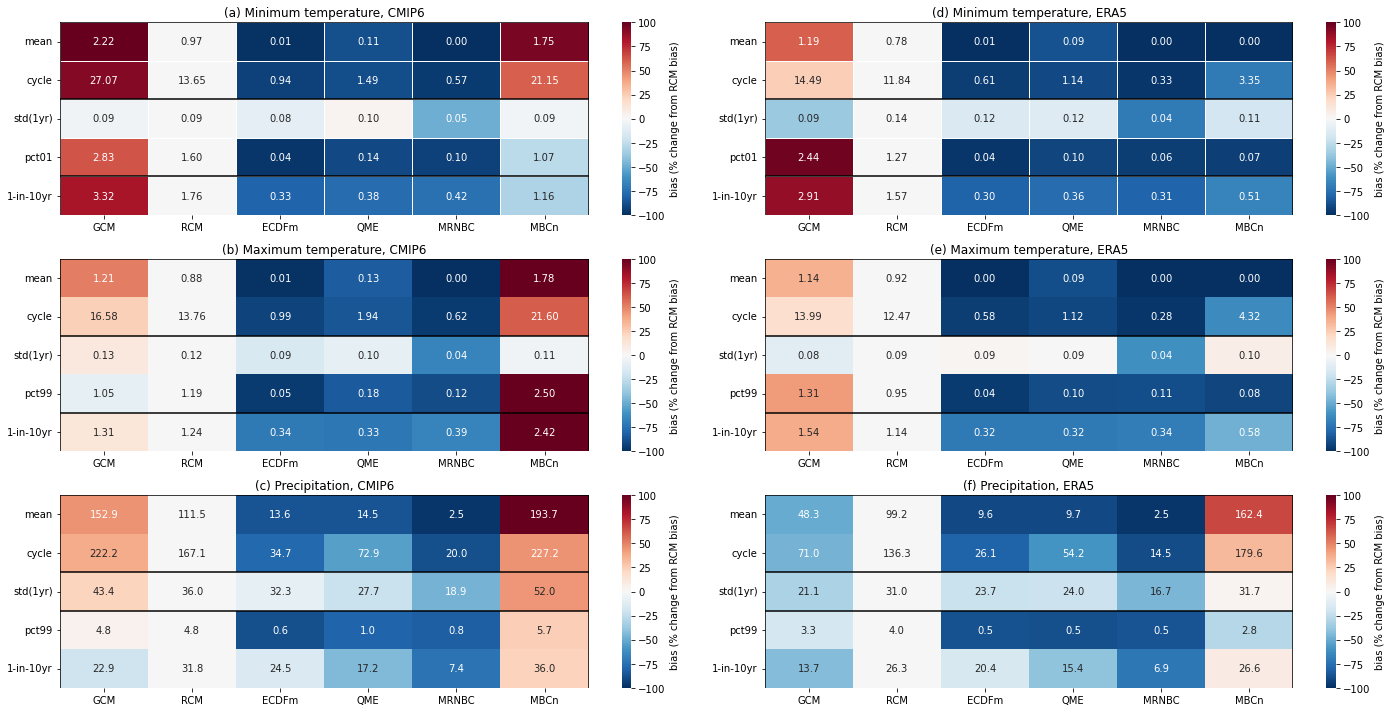

In [6]:
plot_task('hist')

mean figures/mean_bias_tasmin.yaml
cycle figures/seasonal_cycle_tasmin.yaml
std(1yr) figures/interannual_variability_tasmin.yaml
pct01 figures/pct01_tasmin.yaml
1-in-10yr figures/extreme_event_tasmin.yaml
mean figures/mean_bias_tasmax.yaml
cycle figures/seasonal_cycle_tasmax.yaml
std(1yr) figures/interannual_variability_tasmax.yaml
pct99 figures/pct99_tasmax.yaml
1-in-10yr figures/extreme_event_tasmax.yaml
mean figures/mean_bias_pr.yaml
cycle figures/seasonal_cycle_pr.yaml
std(1yr) figures/interannual_variability_pr.yaml
pct99 figures/pct99_pr.yaml
1-in-10yr figures/extreme_event_pr.yaml
mean figures/mean_bias_tasmin.yaml
cycle figures/seasonal_cycle_tasmin.yaml
std(1yr) figures/interannual_variability_tasmin.yaml
pct01 figures/pct01_tasmin.yaml
1-in-10yr figures/extreme_event_tasmin.yaml
mean figures/mean_bias_tasmax.yaml
cycle figures/seasonal_cycle_tasmax.yaml
std(1yr) figures/interannual_variability_tasmax.yaml
pct99 figures/pct99_tasmax.yaml
1-in-10yr figures/extreme_event_tasmax.

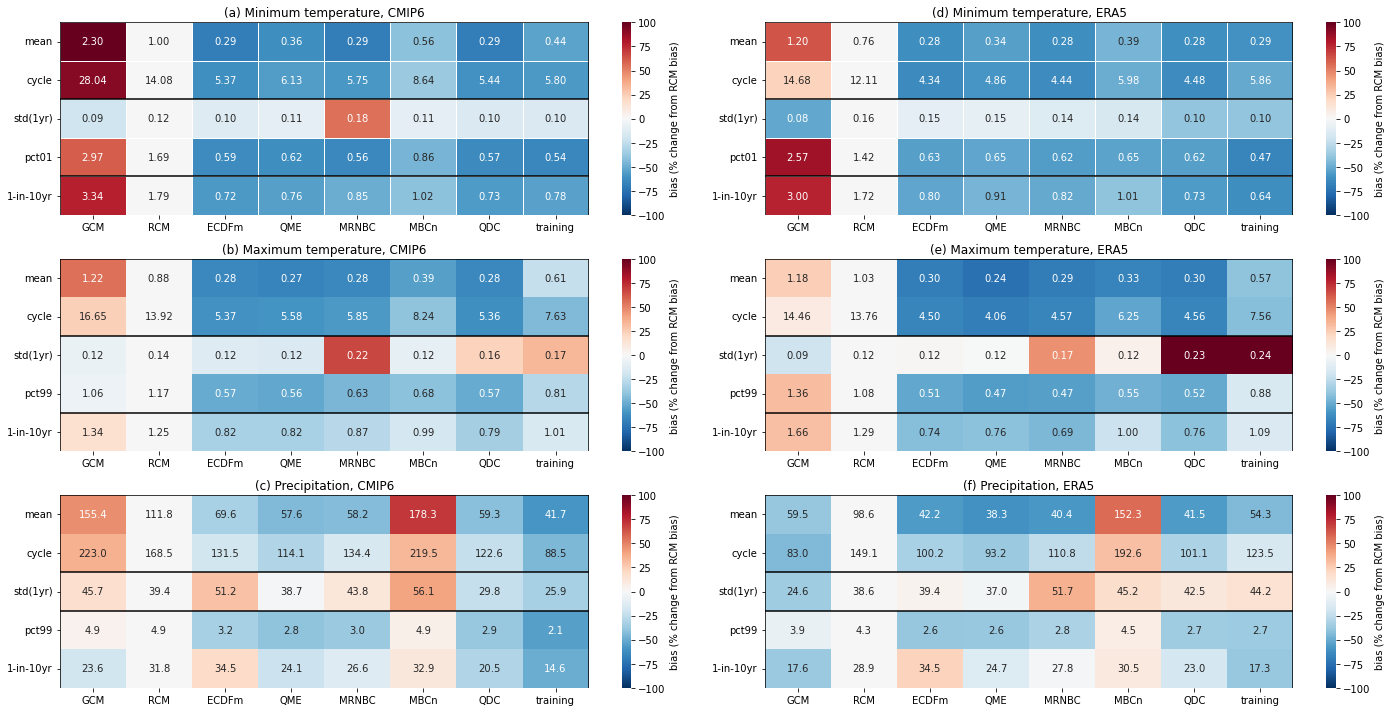

In [7]:
plot_task('xval')